# 2D SITH Ideas
Experimenting with some different ways to create a log-compressed representation of an image invariant to scale

In [489]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import random
from PIL import Image
import torch

In [ ]:
w = 256
h = w
c_x = 128
c_y = 128

In [ ]:
x = np.arange(w)[np.newaxis]
x = np.broadcast_to(x, (w, h))
y = np.arange(h)[:, np.newaxis]
y = np.broadcast_to(y, (w, h))

### 1. Angled/Extended window
This is a somewhat straightforward rotation of the filters, but there may be too many pixels in the integration

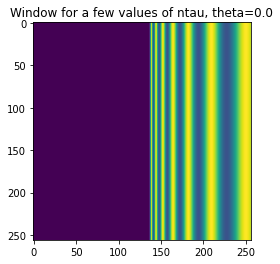

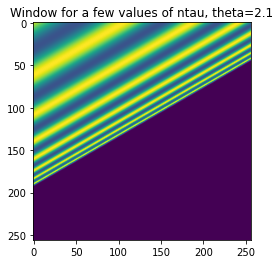

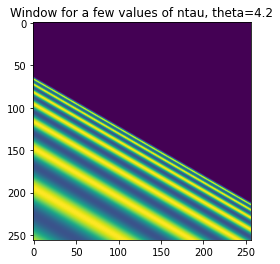

In [ ]:
theta = np.pi / 6
k = 100
eps = 1e-4
tau_min = 16
c = 0.5
num_angles = 3

for ang in range(num_angles):
  im = np.zeros((w, h))
  theta = ang*2*np.pi / num_angles
  for i in range(10):
    tau_star = (1+c)**(i-1) * tau_min

    tau = np.cos(theta)*(x - c_x) - np.sin(theta)*(y - c_y)
    tau[tau <= 0] = eps
    tau_prime = tau / tau_star
    g = k*np.log(tau_prime) - k*tau_prime
    im += np.exp(g)
  
  plt.title(f"Window for a few values of ntau, theta={theta :.2}")
  plt.imshow(im)
  plt.show()

### 2. Circular window
Integrate over a donut-shaped area by setting the input of the windowing function to be the magnitude of the (x, y) pair. 

This would be invariant to rotation (and very tasty), but I think it may be too weak of a representation because of the large area it's integrating over

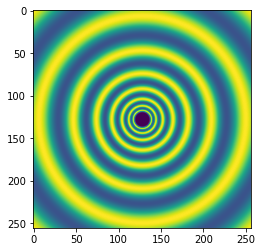

In [ ]:
im = np.zeros((w, h))

for i in range(10):
  tau_star = (1+c)**(i-1) * tau_min

  tau = np.sqrt((x - c_x)**2 + (y - c_y)**2)
  tau[tau <= 0] = eps
  tau_prime = tau / tau_star
  g = k*np.log(tau_prime) - k*tau_prime
  im += np.exp(g)

plt.imshow(im)
plt.show()

### 3. local log-polar transform

This takes the idea of #1 and windows it in the orthogonal direction using a Gaussian. This is great because it captures the local content of an image. 

Here I have the Gaussian's standard deviation scaling with `tau_star` so the windows are as ovals that increase in both dimensions as they get "fuzzier".

For either angled approaches, we'll get a big matrix of size `num_angles * ntau (* num_channels)`. We can either use a convolutional filter+pooling in only the `ntau` direction (scale-invariant) or we can even use a convolutional filter with `filter.height < num_angles` in order to attempt some level of rotation-invariance. We can pad the top/bottom edges with the values from the opposite side so that the operation has the effect of being periodic along the `num_angles` axis.

It turns out there has been research in this area, log-polar representations. Those often seem to interpolate instead of integrating over a larger window that grows as `tau_star` grows. It's possible that using these windows would be more robust to noise.

In [454]:
sd_scale = 2
num_angles = 10
ntau = 30
g = 0
k = 35
tau_min = 16
c = 1

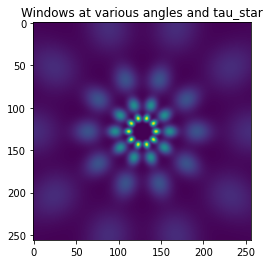

In [455]:
im = np.zeros((w, h))

for ang in range(num_angles):
    theta = ang*(2*np.pi / num_angles)
    theta2 = theta + np.pi/2  # orthogonal direction

    a = np.log(k)*k
    b = np.log(np.arange(2,k)).sum()
    tau_star = tau_min*(1+c)**np.arange(ntau)
    A = (1/tau_star)*(np.exp(a-b))*(tau_star**g)
    
    for i in range(ntau):
      sd = tau_star[i] * sd_scale / num_angles

      tau = np.cos(theta)*(x - c_x) - np.sin(theta)*(y - c_y)
      tau_orth = np.cos(theta2)*(x - c_x) - np.sin(theta2)*(y - c_y)

      gaussian_scale_factor = 1#1/np.sqrt(np.pi*2*sd)
      gauss_window = gaussian_scale_factor * np.exp(-tau_orth**2 / sd**2)

      tau[tau <= 0] = eps
      tau_prime = tau / tau_star[i]
      log_window = k*np.log(tau_prime) - k*tau_prime
      unscaled_window = A[i] * np.exp(log_window)
      window = unscaled_window * gauss_window
      im += window

plt.title("Windows at various angles and tau_star")
plt.imshow(im)
plt.show()

In [512]:
# these parameters work well but don't show up as easily in a visualization
sd_scale = 4
num_angles = 10
ntau = 40
g = 0
k = 35
tau_min = 1
c = 0.2

In [513]:
def create_feature_map(image, center=None):
  w, h = image.shape
  if center is None:
    c_x, c_y = w//2, h//2
  else:
    c_x, c_y = center

  x = np.arange(h)[np.newaxis]
  x = np.broadcast_to(x, (w, h))
  y = np.arange(w)[:, np.newaxis]
  y = np.broadcast_to(y, (w, h))

  result = np.zeros((num_angles, ntau))
  reconstruction = np.zeros(image.shape)
  for ang in range(num_angles):

    theta = ang*(2*np.pi / num_angles)
    theta2 = theta + np.pi/2  # orthogonal direction

    a = np.log(k)*k
    b = np.log(np.arange(2,k)).sum()
    tau_star = tau_min*(1+c)**np.arange(ntau)
    A = (1/tau_star)*(np.exp(a-b))*(tau_star**g)
    
    for i in range(ntau):
      sd = tau_star[i] * sd_scale / num_angles

      tau = np.cos(theta)*(x - c_x) - np.sin(theta)*(y - c_y)
      #plt.imshow(tau)
      #plt.show()
      tau_orth = np.cos(theta2)*(x - c_x) - np.sin(theta2)*(y - c_y)

      #gaussian_scale_factor = np.sqrt(sd) # this is just a heuristic--the inner activations were overpowering the outer ones
      #gaussian_scale_factor = 1
      gaussian_scale_factor = 1/np.sqrt(np.pi*2*sd)
      gauss_window = gaussian_scale_factor * np.exp(-tau_orth**2 / sd)

      tau[tau <= 0] = eps
      tau_prime = tau / tau_star[i]
      log_window = k*np.log(tau_prime) - k*tau_prime
      unscaled_window = A[i] * np.exp(log_window)
      window = unscaled_window * gauss_window
      #print(window.flatten().sum(), gauss_window.sum(), unscaled_window.flatten().sum())
      res = image.flatten() @ window.flatten()
      reconstruction += res * window
      result[ang, i] = res

  #plt.imshow(reconstruction)
  #plt.show()
  return result

### Results of #3

In [514]:
mnist_train = MNIST("data/MNIST", train=True, download=True)

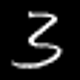

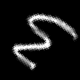

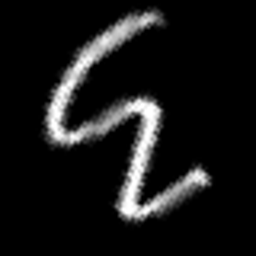

In [529]:
idx = random.randint(0, len(mnist_train)-1)
image = mnist_train[idx][0]
resized = image.resize((80, 80))
rotated = resized.rotate(144)
rotated2 = resized.rotate(215).resize((256, 256))
#create_feature_map(np.array(image))
display(image)
display(resized)
display(rotated)
display(rotated2)

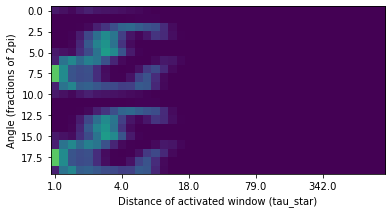

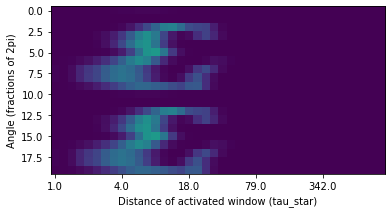

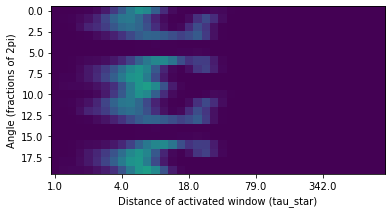

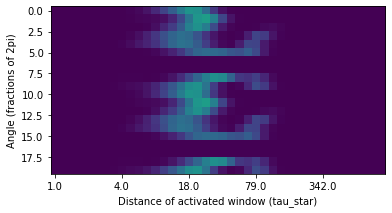

In [530]:
logpixel_range = np.arange(ntau, step=ntau//5)
pixel_range = np.round(tau_min*(1+c)**logpixel_range)

for im in [image, resized, rotated, rotated2]:
  feature_map = create_feature_map(np.array(im))
  plt.xlabel("Distance of activated window (tau_star)")
  plt.ylabel("Angle (fractions of 2pi)")
  plt.xticks(logpixel_range, pixel_range)
  plt.imshow(np.concatenate([feature_map, feature_map], axis=0), vmax=300)
  plt.show()

Scale and rotation both now become translation in the feature space!

### How does the log-polar transform vary within/between digits?
Each row includes a few samples of a digit without transformation

In [531]:
num_digits = 10
samples_per_digit = 5
feature_maps = [[] for _ in range(num_digits)]

for im, label in mnist_train:
  if len(feature_maps[label]) < samples_per_digit:
    feature_maps[label].append(create_feature_map(np.array(im)))

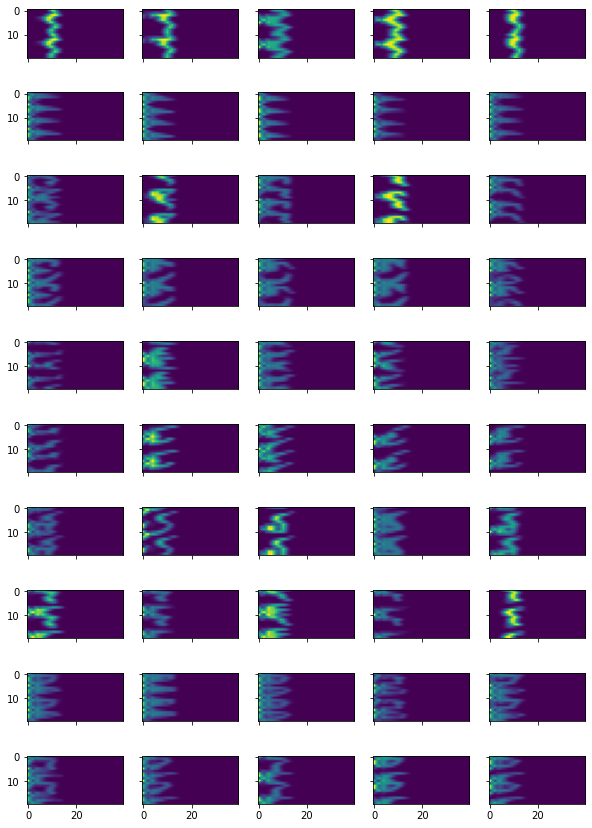

In [518]:
# the rows are the digits 0-9, and each row has a few examples of a digit
fig, ax = plt.subplots(num_digits, samples_per_digit, sharex=True, sharey=True, figsize=(10, 15))
for i in range(num_digits):
  for j in range(samples_per_digit):
    
    feature_map = feature_maps[i][j]
    ax[i, j].imshow(np.concatenate([feature_map, feature_map], axis=0))
  
plt.show()

### Adapting to Translation?

In [519]:
def translate_image(im, dx, dy, resize=True):
  """
  Translate the image dx, dy from the center, 
    optionally expanding the image to fit.
  """
  w, h = im.size
  new_size = (w+abs(dx), h+abs(dy)) if resize else im.size
  out = Image.new(im.mode, new_size)
  offset = (max(dx, 0), max(dy, 0))
  out.paste(im, offset)
  return out

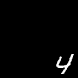

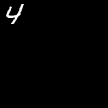

In [520]:
idx = random.randint(0, len(mnist_train)-1)
image = mnist_train[idx][0]
t1 = translate_image(image, 5, 0)
t2 = translate_image(image, 10, 0)
t3 = translate_image(image, 50, 50)
t4 = translate_image(image, -80, -80)

display(image)
display(t1)
display(t2)
display(t3)
display(t4)

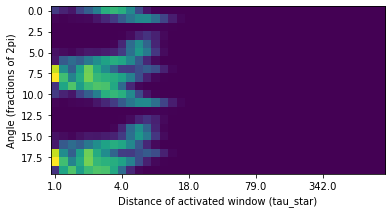

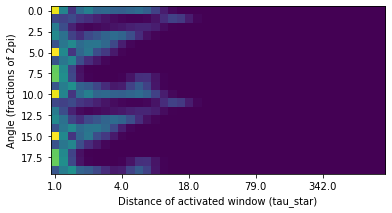

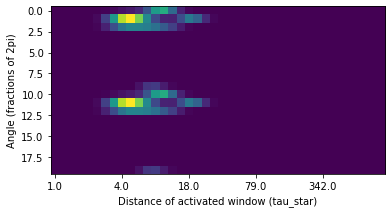

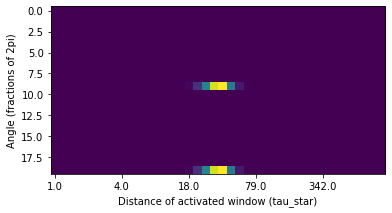

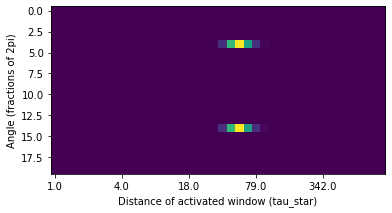

In [521]:
logpixel_range = np.arange(ntau, step=ntau//5)
pixel_range = np.round(tau_min*(1+c)**logpixel_range)

for im in [image, t1, t2, t3, t4]:
  feature_map = create_feature_map(np.array(im))
  plt.xlabel("Distance of activated window (tau_star)")
  plt.ylabel("Angle (fractions of 2pi)")
  plt.xticks(logpixel_range, pixel_range)
  plt.imshow(np.concatenate([feature_map, feature_map], axis=0))
  plt.show()

Not so good

In [522]:
def create_feature_maps(im, div=2):
  # compute log-polar transform of the image from the perspective of various
  #.  points in the image: a grid of (dix+1)*(div+1) equally spaced pixels
  w, h = im.shape
  w_split = w // div
  h_split = h // div
  res = [[None] * (div+1) for _ in range(div+1)]
  for i in range(div+1):
    for j in range(div+1):
      c_x = w_split * i
      c_y = h_split * j
      res[i][j] = create_feature_map(im, (c_x, c_y))

  return res


def show_feature_maps(im, div=2):
  # display the results from above
  feature_maps = create_feature_maps(np.array(im), div)
  fig, ax = plt.subplots(div+1, div+1, sharex=True, sharey=True)

  for i in range(div+1):
    for j in range(div+1):
      feature_map = feature_maps[i][j]
      ax[i, j].imshow(np.concatenate([feature_map, feature_map], axis=0), aspect='auto')

  plt.show()

In [523]:
div = 4

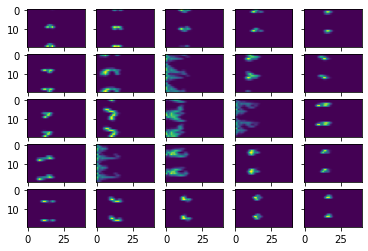

In [524]:
show_feature_maps(image, div)

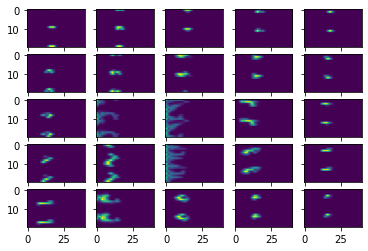

In [525]:
show_feature_maps(t1, div)

In [526]:
def unsqueeze_except(X, n_dim, dim=0):
  """
  Make X start at the dim'th dimension in an n_dim tensor.
  
  Example:
    unsqueeze_except(X, 4, 1) with X.shape = (128,) -> (1, 128, 1 1)
  """
  dim = (dim + n_dim) % n_dim
  assert n_dim - dim >= len(X.shape)
  res = X
  for i in range(dim):
    res = res[np.newaxis]
  for i in range(n_dim-dim-len(X.shape)):
    res = res[..., np.newaxis]
  return res

X = np.zeros((128,25))
unsqueeze_except(X, 10, 3).shape

(1, 1, 1, 128, 25, 1, 1, 1, 1, 1)

In [527]:
def safe_log(X):
  # only take the log of nonzero numbers
  out = torch.zeros_like(X)
  out[X > 0] = torch.log(X[X > 0])
  return out

### Computing the log-polar transform for each pixel using a 2D convolution

In [528]:
class iSITH2D(torch.nn.Module):
    def __init__(self, tau_min=.1, tau_max=100., buff_max=None, k=50, 
                 ntau=50, dt=1, g=0.0, stride=1, num_angles=10,
                 ttype=torch.FloatTensor, **kwargs):
        super(iSITH2D, self).__init__()
        """A SITH module using the perfect equation for the resulting ftilde .... for 2D images?
        
        Parameters
        ----------
        
            - tau_min: float
                The center of the spatial receptive field for the first taustar produced. 
            - tau_max: float
                The center of the spatial receptive field for the last taustar produced. 
            - buff_max: int
                The maximum time in which the filters go into the past. NOTE: In order to 
                achieve as few edge effects as possible, buff_max needs to be bigger than
                tau_max, and dependent on k, such that the filters have enough time to reach 
                very close to 0.0. Plot the filters and you will see them go to 0. 
            - k: int
                Spatial Specificity of the taustars. If this number is high, then taustars
                will always be more narrow.
            - ntau: int
                Number of taustars produced, spread out logarithmically.
            - dt: float
                The space delta of the model. The there will be int(buff_max/dt) filters per
                taustar. Essentially this is the base rate of information being presented to the model
            - g: float
                Typically between 0 and 1. This parameter is the scaling factor of the output
                of the module. If set to 1, the output amplitude for a delta function will be
                identical through time. If set to 0, the amplitude will decay into the past, 
                getting smaller and smaller. This value should be picked on an application to 
                application basis.
            - num_angles: int
                How many angles to compute the SITH across.
            - stride: int
                The stride the convolution will take over the image. If greater than 1,
                the output will be effectively downsampled.
            - ttype: Torch Tensor
                This is the type we set the internal mechanism of the model to before running. 
                In order to calculate the filters, we must use a DoubleTensor, but this is no 
                longer necessary after they are calculated. By default we set the filters to 
                be FloatTensors. NOTE: If you plan to use CUDA, you need to pass in a 
                cuda.FloatTensor as the ttype, as using .cuda() will not put these filters on 
                the gpu.                 
        """

        self.k = k
        self.tau_min = tau_min
        self.tau_max = tau_max
        if buff_max is None:
            buff_max = 3*tau_max
        self.buff_max = buff_max
        self.ntau = ntau
        self.dt = dt
        self.g = g
        self.stride = stride
        self.num_angles = num_angles

        self.c = (tau_max/tau_min)**(1./(ntau-1))-1
        
        x = torch.arange(dt, buff_max+dt, dt).type(torch.DoubleTensor)
        y = torch.arange(dt, buff_max+dt, dt).type(torch.DoubleTensor)
        filter_width = len(x)
        self.padding = filter_width // 2
        # the center point for each filter
        c_x = c_y = (buff_max+dt) // 2

        theta = (torch.arange(num_angles) / num_angles) * 2*torch.pi
        tau_star = tau_min*(1+self.c)**torch.arange(ntau).type(torch.DoubleTensor)

        # we'll need ALL combinations of (x, y, theta, tau_star), so make 
        #   all tensors broadcastable to that shape
        ndim = 4
        x = unsqueeze_except(x, ndim, dim=0)
        y = unsqueeze_except(y, ndim, dim=1)
        theta = unsqueeze_except(theta, ndim, dim=2)
        tau_star = unsqueeze_except(tau_star, ndim, dim=3)

        a = torch.log(k)*k
        b = torch.log(torch.arange(2,k).type(torch.DoubleTensor)).sum()
        
        A = ((1/self.tau_star)*(torch.exp(a-b))*(self.tau_star**self.g))
        A = unsqueeze_except(A, ndim, dim=0)
        
        
        tau = torch.cos(theta)*(x - c_x) - torch.sin(theta)*(y - c_y)
        gaussian_scale_factor = 1/np.sqrt(np.pi*2*sd)
        gauss_window = gaussian_scale_factor * np.exp(-tau_orth**2 / sd)

        tau[tau <= 0] = 0
        tau_prime = tau / tau_star[i]
        tau_prime = tau / tau_star

        self.filters = A*torch.exp(safe_log(tau_prime)*(k+1) - k*tau_prime)
        self.filters[tau_prime <= 0] = 0

        # reshape to filter with ntau*num_angles channels
        self.filters.permute_(3, 4, 0, 1) 
        self.filters.reshape_((ntau*num_angles, filter_width, filter_width))
        #self.filters = torch.flip(self.filters, [-1]).unsqueeze(1).unsqueeze(1)
        self.filters = self.filters.type(ttype)
    

    def extra_repr(self):
        s = "ntau={ntau}, tau_min={tau_min}, tau_max={tau_max}, buff_max={buff_max}, dt={dt}, k={k}, g={g}"
        s = s.format(**self.__dict__)
        return s    
    

    def forward(self, inp):
        """
        Takes in (Batch, 1, features, x, y) and returns (Batch, Taustar, Theta, features, x', y')
        x' and y' may be smaller than x and y if self.stride != 1
        """
        # TODO: Implement forward
        assert(len(inp.shape) >= 5)
        inp = inp.squeeze(1)        
        out = torch.conv2d(inp, self.filters[:, :, :, -inp.shape[-1]:], 
                           padding=[0, self.filters[:, :, :, -inp.shape[-1]:].shape[-1]])
                           #padding=[0, self.filters.shape[-1]])
        # note we're scaling the output by both dt and the k/(k+1)
        # Off by 1 introduced by the conv2d
        return out[:, :, :, 1:inp.shape[-1]+1]*self.dt*self.k/(self.k+1)